In [1]:
import numpy as np
import pandas as pd

import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import rcParams
import seaborn as sns

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, precision_recall_curve

from sklearn.linear_model import LogisticRegression

import gensim

sns.set_style("whitegrid")
sns.set_context("poster")
rcParams['figure.figsize'] = (12.5, 11)
rcParams['figure.dpi'] = 250
rcParams['font.size'] = 12

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def plot_LSA(test_data, test_labels, legend_labels):

    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    labels = sorted(set(test_labels))
    fig = plt.figure(figsize=(16, 16))

    for label in labels:

        indices = (test_labels == label)
        plt.scatter(lsa_scores[:,0][indices], lsa_scores[:,1][indices], s=8, alpha=.4)

    plt.legend(legend_labels)

In [0]:
def calc_metrics(y_test, y_pred):
  
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print("Accuracy: {0:.2f}%".format(100*accuracy))
    print("Precision: {0:.2f}%".format(precision))
    print("Recall: {0:.2f}%".format(recall))
    print("F1 score: {0:.2f}%".format(f1))

In [0]:
def plot_cm(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.show()

In [0]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/data/df_cleaned.csv")

In [7]:
df.head()

,Unnamed: 0,helpful,not_helpful,score,summary,text
0,0,1,0,1,"['good', 'quality', 'dog', 'food']","['i', 'have', 'bought', 'several', 'of', 'the'..."
1,1,0,0,0,"['not', 'as', 'advertised']","['product', 'arrived', 'labeled', 'as', 'jumbo..."
2,2,1,0,1,"['delight', 'says', 'it', 'all']","['this', 'is', 'a', 'confection', 'that', 'has..."
3,3,3,0,0,"['cough', 'medicine']","['if', 'you', 'are', 'looking', 'for', 'the', ..."
4,4,0,0,1,"['great', 'taffy']","['great', 'taffy', 'at', 'a', 'great', 'price'..."


## Bags of Words

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df.text.values, df.score.values, test_size=0.2, random_state=40)

cv = CountVectorizer()
X_train_counts = cv.fit_transform(X_train)
X_test_counts = cv.transform(X_test)

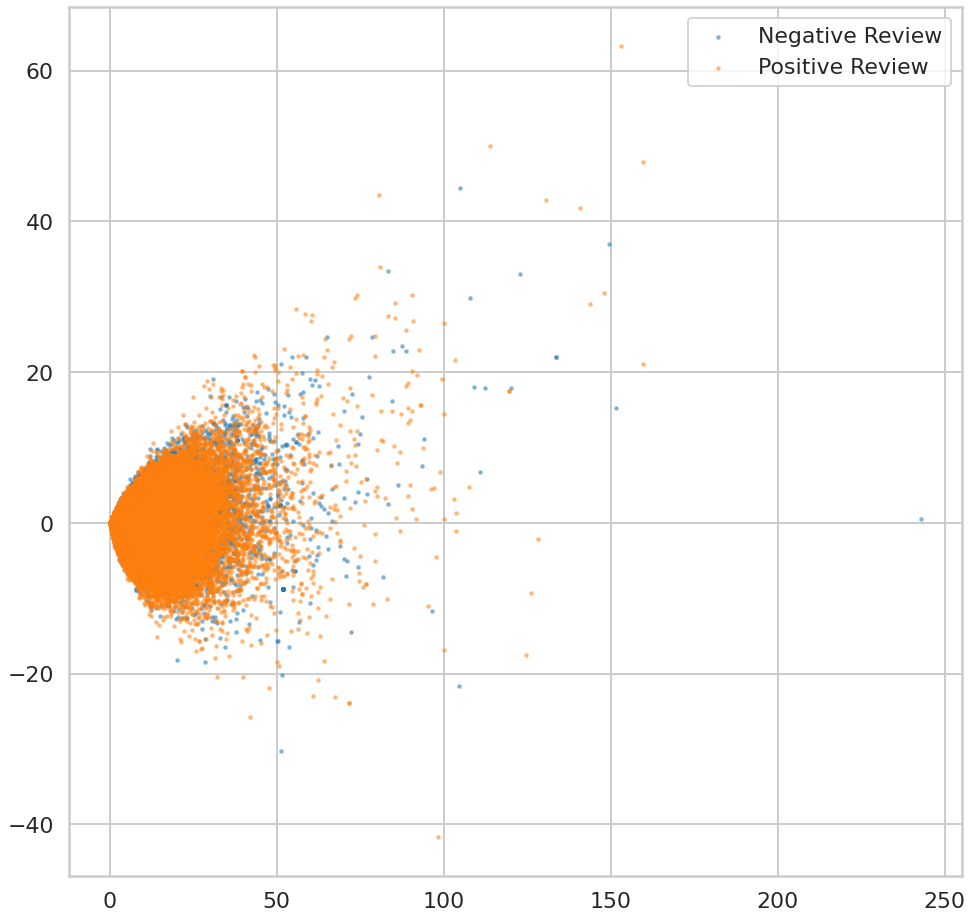

In [9]:
plot_LSA(X_train_counts, y_train, ['Negative Review', 'Positive Review'])
plt.show()

In [0]:
clf_bow = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf_bow.fit(X_train_counts, y_train)

y_predicted_counts = clf_bow.predict(X_test_counts)
bow_probs = clf_bow.predict_proba(X_test_counts)[:, 1]

In [11]:
calc_metrics(y_test, y_predicted_counts)

Accuracy: 85.51%
Precision: 0.93%
Recall: 0.88%
F1 score: 0.90%


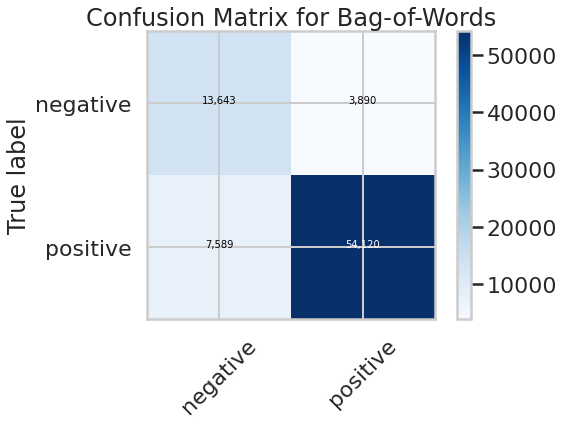

In [12]:
plot_cm(confusion_matrix(y_test, y_predicted_counts), ['negative', 'positive'], "Confusion Matrix for Bag-of-Words", normalize=False)

## TF-IDF Bag of Words

In [0]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

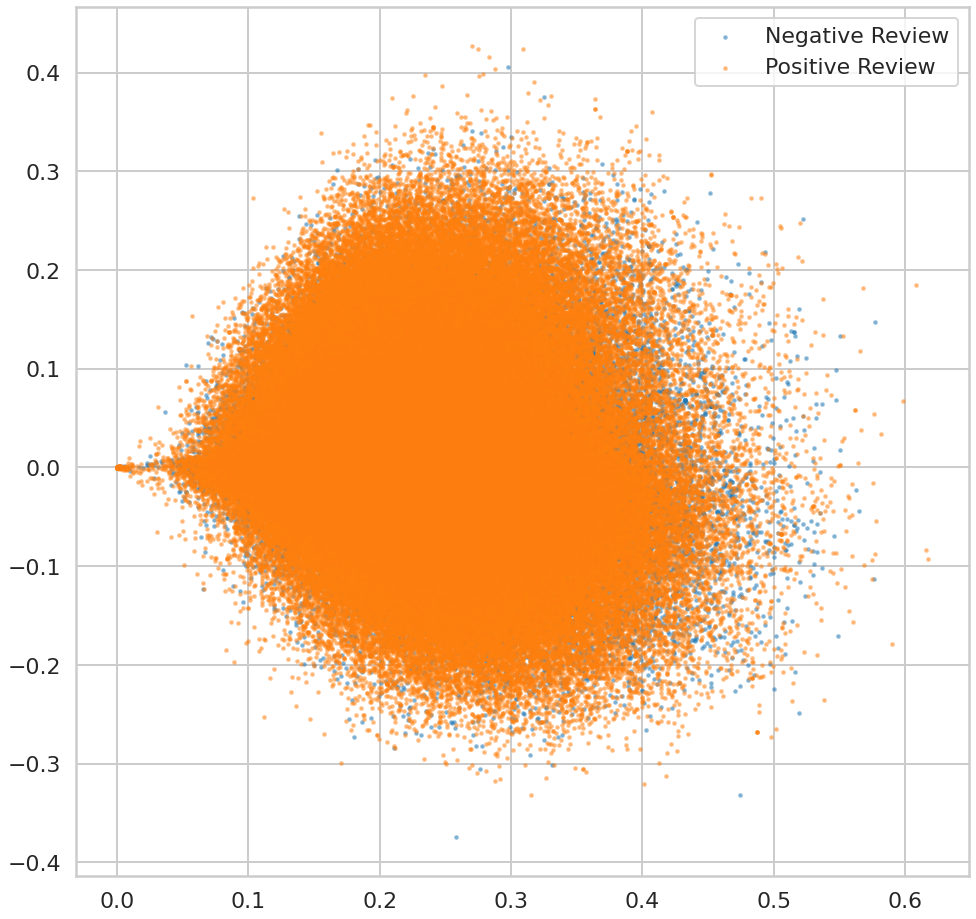

In [14]:
plot_LSA(X_train_tfidf, y_train, ['Negative Review', 'Positive Review'])
plt.show()

In [0]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)
tfidf_probs = clf_tfidf.predict_proba(X_test_tfidf)[:, 1]

In [16]:
calc_metrics(y_test, y_predicted_tfidf)

Accuracy: 86.60%
Precision: 0.95%
Recall: 0.88%
F1 score: 0.91%


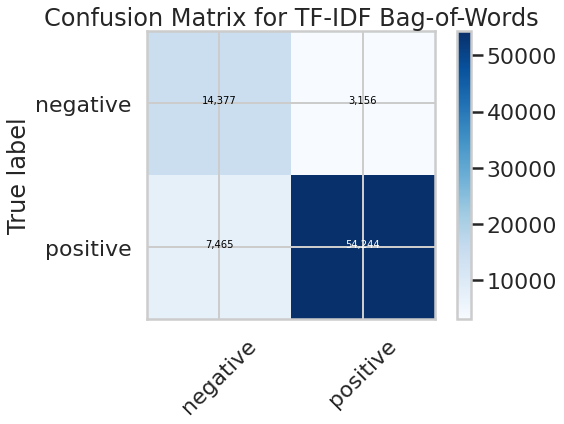

In [17]:
plot_cm(confusion_matrix(y_test, y_predicted_tfidf), ['negative', 'positive'], "Confusion Matrix for TF-IDF Bag-of-Words", normalize=False)

## Word2vec

In [18]:
word2vec_path = "drive/My Drive/Colab Notebooks/GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):

    if len(tokens_list)<1:
        return(np.zeros(k))

    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]

    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]

    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)

    return(averaged)

In [0]:
def get_word2vec_embeddings(vectors, tokens_series, generate_missing=False):

    embeddings = tokens_series.apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    
    return(list(embeddings))

In [0]:
embeddings = get_word2vec_embeddings(word2vec, df.text)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, df.score.values, test_size=0.2, random_state=40)

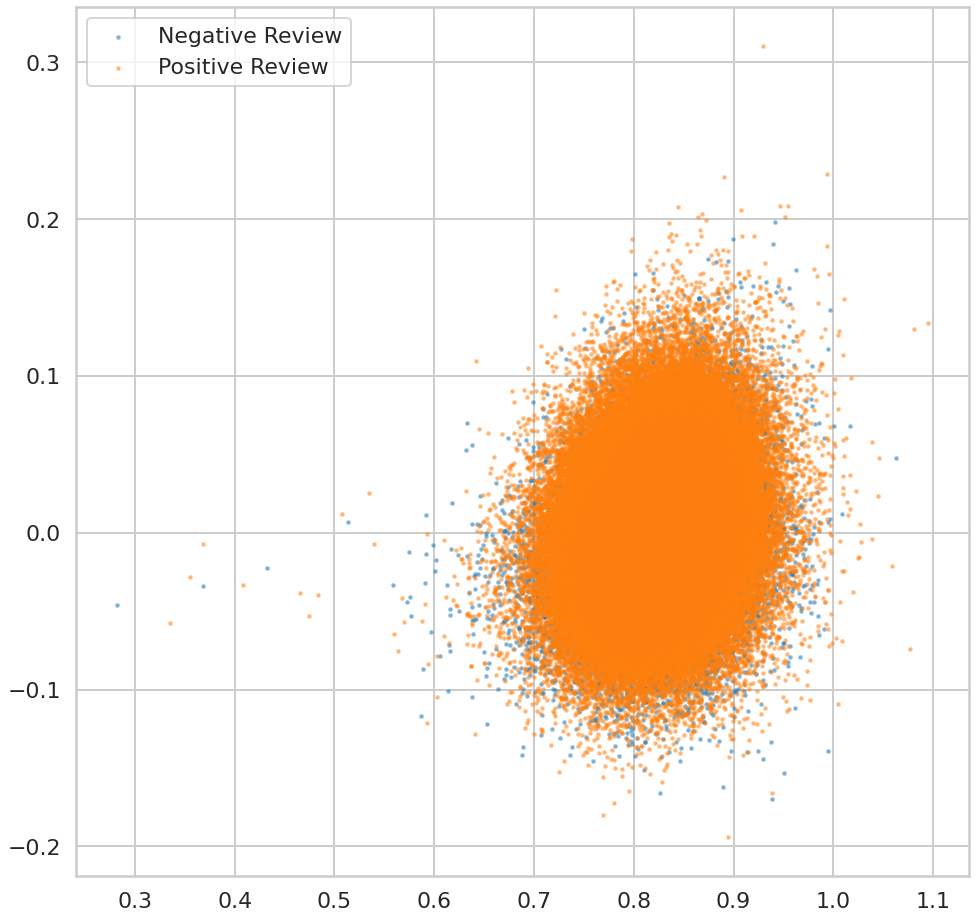

In [22]:
plot_LSA(X_train_word2vec, y_train_word2vec, ['Negative Review', 'Positive Review'])
plt.show()

In [0]:
clf_word2vec = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', multi_class='multinomial', random_state=40)
clf_word2vec.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_word2vec.predict(X_test_word2vec)
word2vec_probs = clf_word2vec.predict_proba(X_test_word2vec)[:, 1]

In [24]:
calc_metrics(y_test_word2vec, y_predicted_word2vec)

Accuracy: 63.24%
Precision: 0.86%
Recall: 0.63%
F1 score: 0.73%


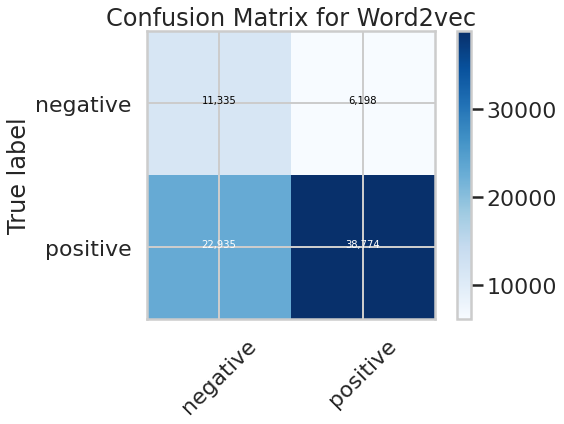

In [25]:
plot_cm(confusion_matrix(y_test_word2vec, y_predicted_word2vec), ['negative', 'positive'], "Confusion Matrix for Word2vec", normalize=False)

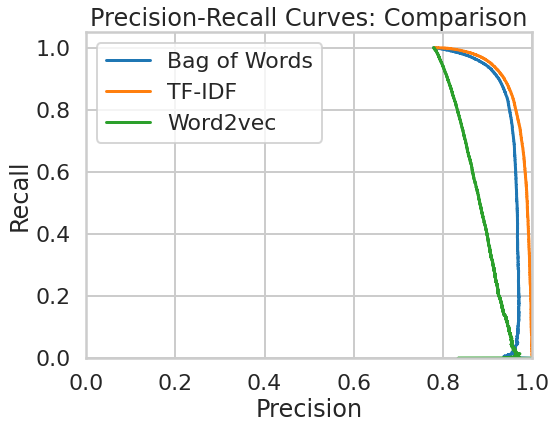

In [26]:
probs = [bow_probs, tfidf_probs, word2vec_probs]
y_test_array = [y_test, y_test, y_test_word2vec]

plt.figure(figsize=(8, 6))

for prob, y_test in zip(probs, y_test_array):

    precision, recall, _ = precision_recall_curve(y_test, prob)
    plt.plot(precision, recall)

plt.title("Precision-Recall Curves: Comparison")
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(["Bag of Words", "TF-IDF", "Word2vec"])